<a href="https://colab.research.google.com/github/2uangloc/CNN-Based-Anomaly-Detection-for-Network-Traffic/blob/main/CNN_PFSENSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import thư viện
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Conv1D, Activation,MaxPooling1D,Flatten, GRU, AveragePooling1D, Dense, Dropout
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import TensorBoard
import sklearn
from sklearn.impute import SimpleImputer
!pip install gdown==4.6.3
import gdown



  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [2]:
url = 'https://drive.google.com/uc?id=1DVx4u_ycIkZXPZOnK4EabvKE9JIPWh2M'
output = 'logpfSense.txt'
print(output)
gdown.download(url, output, quiet=False)


logpfSense.txt


Downloading...
From: https://drive.google.com/uc?id=1DVx4u_ycIkZXPZOnK4EabvKE9JIPWh2M
To: /content/logpfSense.txt
100%|██████████| 14.5M/14.5M [00:00<00:00, 89.5MB/s]


'logpfSense.txt'

In [3]:
#tạo cái thuộc tính của dữ liệu
feature = ["Timestamp","GID","SID","Event Ref ID","Message",
           "Protocol","Src IP","Src Port","Dst IP","Dst Port",
           "Extra Port","Description","Priority","Event","Action"]


In [4]:
# Đọc dữ liệu
data = pd.read_csv(output,header=None, names=feature)
data


,Timestamp,GID,SID,Event Ref ID,Message,Protocol,Src IP,Src Port,Dst IP,Dst Port,Extra Port,Description,Priority,Event,Action
0,01/14/24-23:36:19.380025,1,13,0,Normal,ICMP,192.168.8.10,NaN,192.168.10.30,NaN,135,Generic ICMP event,3,alert,Allow
1,01/14/24-23:36:19.380025,1,8,0,Normal,ICMP,192.168.8.10,NaN,192.168.10.30,NaN,135,Generic ICMP event,4,alert,Allow
2,01/14/24-23:36:19.380025,1,2,0,Normal,ICMP,192.168.8.10,NaN,192.168.10.30,NaN,135,Generic ICMP event,4,alert,Allow
3,01/14/24-23:36:19.380543,1,1,0,Ping of death!,ICMP,192.168.10.30,NaN,192.168.8.10,NaN,40480,Denial of Service,2,alert,Allow
4,01/14/24-23:36:19.380580,1,1,0,Ping of death!,ICMP,192.168.10.30,NaN,192.168.8.10,NaN,40481,Denial of Service,2,alert,Allow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121845,01/14/24-23:37:34.369679,1,5,0,SYN Flood,TCP,54.134.244.223,62847.0,192.168.10.30,0.0,40539,Detection of a Denial of Service Attack,2,alert,Allow
121846,01/14/24-23:37:34.618594,1,5,0,SYN Flood,TCP,140.91.163.79,7387.0,192.168.10.30,0.0,28538,Detection of a Denial of Service Attack,2,alert,Allow
121847,01/14/24-23:37:34.774994,1,5,0,SYN Flood,TCP,232.41.169.121,14907.0,192.168.10.30,0.0,45028,Detection of a Denial of Service Attack,2,alert,Allow
121848,01/14/24-23:37:35.149873,1,5,0,SYN Flood,TCP,174.99.238.61,31527.0,192.168.10.30,0.0,3830,Detection of a Denial of Service Attack,2,alert,Allow


In [5]:
# Chia cột IP thành 4 cột, đồng thời loại bỏ các cột không cần thiết như Timestamp,
# Action; Src IP và Dst IP đã được chia cột rồi nên bỏ luôn
data[['Src IP1', 'Src IP2', 'Src IP3', 'Src IP4']] = data['Src IP'].str.split('.', expand=True)
data[['Dst IP1', 'Dst IP2', 'Dst IP3', 'Dst IP4']] = data['Src IP'].str.split('.', expand=True)
delete_columns=['Timestamp','Src IP','Dst IP','Action']

data = data.drop(columns=delete_columns)
data.info()
data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121850 entries, 0 to 121849
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   GID           121850 non-null  int64  
 1   SID           121850 non-null  int64  
 2   Event Ref ID  121850 non-null  int64  
 3   Message       121850 non-null  object 
 4   Protocol      121850 non-null  object 
 5   Src Port      83830 non-null   float64
 6   Dst Port      83830 non-null   float64
 7   Extra Port    121850 non-null  int64  
 8   Description   121850 non-null  object 
 9   Priority      121850 non-null  int64  
 10  Event         121850 non-null  object 
 11  Src IP1       121850 non-null  object 
 12  Src IP2       121850 non-null  object 
 13  Src IP3       121850 non-null  object 
 14  Src IP4       121850 non-null  object 
 15  Dst IP1       121850 non-null  object 
 16  Dst IP2       121850 non-null  object 
 17  Dst IP3       121850 non-null  object 
 18  Dst 

,GID,SID,Event Ref ID,Message,Protocol,Src Port,Dst Port,Extra Port,Description,Priority,Event,Src IP1,Src IP2,Src IP3,Src IP4,Dst IP1,Dst IP2,Dst IP3,Dst IP4
0,1,13,0,Normal,ICMP,NaN,NaN,135,Generic ICMP event,3,alert,192,168,8,10,192,168,8,10
1,1,8,0,Normal,ICMP,NaN,NaN,135,Generic ICMP event,4,alert,192,168,8,10,192,168,8,10
2,1,2,0,Normal,ICMP,NaN,NaN,135,Generic ICMP event,4,alert,192,168,8,10,192,168,8,10
3,1,1,0,Ping of death!,ICMP,NaN,NaN,40480,Denial of Service,2,alert,192,168,10,30,192,168,10,30
4,1,1,0,Ping of death!,ICMP,NaN,NaN,40481,Denial of Service,2,alert,192,168,10,30,192,168,10,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121845,1,5,0,SYN Flood,TCP,62847.0,0.0,40539,Detection of a Denial of Service Attack,2,alert,54,134,244,223,54,134,244,223
121846,1,5,0,SYN Flood,TCP,7387.0,0.0,28538,Detection of a Denial of Service Attack,2,alert,140,91,163,79,140,91,163,79
121847,1,5,0,SYN Flood,TCP,14907.0,0.0,45028,Detection of a Denial of Service Attack,2,alert,232,41,169,121,232,41,169,121
121848,1,5,0,SYN Flood,TCP,31527.0,0.0,3830,Detection of a Denial of Service Attack,2,alert,174,99,238,61,174,99,238,61


In [6]:
#số lượng nhãn tấn công
data.Description.value_counts()
data.Message.value_counts()


UDP Flood         82570
Ping of death!    37963
SYN Flood          1235
Normal               82
Name: Message, dtype: int64

In [7]:
data[data.isna().any(axis=1)]

,GID,SID,Event Ref ID,Message,Protocol,Src Port,Dst Port,Extra Port,Description,Priority,Event,Src IP1,Src IP2,Src IP3,Src IP4,Dst IP1,Dst IP2,Dst IP3,Dst IP4
0,1,13,0,Normal,ICMP,NaN,NaN,135,Generic ICMP event,3,alert,192,168,8,10,192,168,8,10
1,1,8,0,Normal,ICMP,NaN,NaN,135,Generic ICMP event,4,alert,192,168,8,10,192,168,8,10
2,1,2,0,Normal,ICMP,NaN,NaN,135,Generic ICMP event,4,alert,192,168,8,10,192,168,8,10
3,1,1,0,Ping of death!,ICMP,NaN,NaN,40480,Denial of Service,2,alert,192,168,10,30,192,168,10,30
4,1,1,0,Ping of death!,ICMP,NaN,NaN,40481,Denial of Service,2,alert,192,168,10,30,192,168,10,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38015,1,1,0,Ping of death!,ICMP,NaN,NaN,12944,Denial of Service,2,alert,192,168,10,30,192,168,10,30
38016,1,1,0,Ping of death!,ICMP,NaN,NaN,12945,Denial of Service,2,alert,192,168,10,30,192,168,10,30
38017,1,1,0,Ping of death!,ICMP,NaN,NaN,12946,Denial of Service,2,alert,192,168,10,30,192,168,10,30
38018,1,1,0,Ping of death!,ICMP,NaN,NaN,12947,Denial of Service,2,alert,192,168,10,30,192,168,10,30


In [8]:
#tính giá trị trung bình của cột "Src Port"
mean_value_src = data["Src Port"].mean()
print(mean_value_src)

28194.501872837885


In [9]:
#tính giá trị trung bình của cột "Dst Port"
mean_value_dst = data["Dst Port"].mean()
print(mean_value_dst)


0.0


In [10]:
#xử lý giá trị NaN bằng cách thay đổi thành giá trị trung bình
data.loc[data['Src Port'].isna(),"Src Port"] =mean_value_src #Giá trị trung bình trong cột
data.loc[data['Dst Port'].isna(),"Dst Port"] =mean_value_dst #Giá trị trung bình trong cột


In [11]:
data

,GID,SID,Event Ref ID,Message,Protocol,Src Port,Dst Port,Extra Port,Description,Priority,Event,Src IP1,Src IP2,Src IP3,Src IP4,Dst IP1,Dst IP2,Dst IP3,Dst IP4
0,1,13,0,Normal,ICMP,28194.501873,0.0,135,Generic ICMP event,3,alert,192,168,8,10,192,168,8,10
1,1,8,0,Normal,ICMP,28194.501873,0.0,135,Generic ICMP event,4,alert,192,168,8,10,192,168,8,10
2,1,2,0,Normal,ICMP,28194.501873,0.0,135,Generic ICMP event,4,alert,192,168,8,10,192,168,8,10
3,1,1,0,Ping of death!,ICMP,28194.501873,0.0,40480,Denial of Service,2,alert,192,168,10,30,192,168,10,30
4,1,1,0,Ping of death!,ICMP,28194.501873,0.0,40481,Denial of Service,2,alert,192,168,10,30,192,168,10,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121845,1,5,0,SYN Flood,TCP,62847.000000,0.0,40539,Detection of a Denial of Service Attack,2,alert,54,134,244,223,54,134,244,223
121846,1,5,0,SYN Flood,TCP,7387.000000,0.0,28538,Detection of a Denial of Service Attack,2,alert,140,91,163,79,140,91,163,79
121847,1,5,0,SYN Flood,TCP,14907.000000,0.0,45028,Detection of a Denial of Service Attack,2,alert,232,41,169,121,232,41,169,121
121848,1,5,0,SYN Flood,TCP,31527.000000,0.0,3830,Detection of a Denial of Service Attack,2,alert,174,99,238,61,174,99,238,61


In [12]:
data[data.isna().any(axis=1)]

,GID,SID,Event Ref ID,Message,Protocol,Src Port,Dst Port,Extra Port,Description,Priority,Event,Src IP1,Src IP2,Src IP3,Src IP4,Dst IP1,Dst IP2,Dst IP3,Dst IP4


In [13]:
# Số lượng nhãn tấn công
data['Message'].value_counts()

UDP Flood         82570
Ping of death!    37963
SYN Flood          1235
Normal               82
Name: Message, dtype: int64

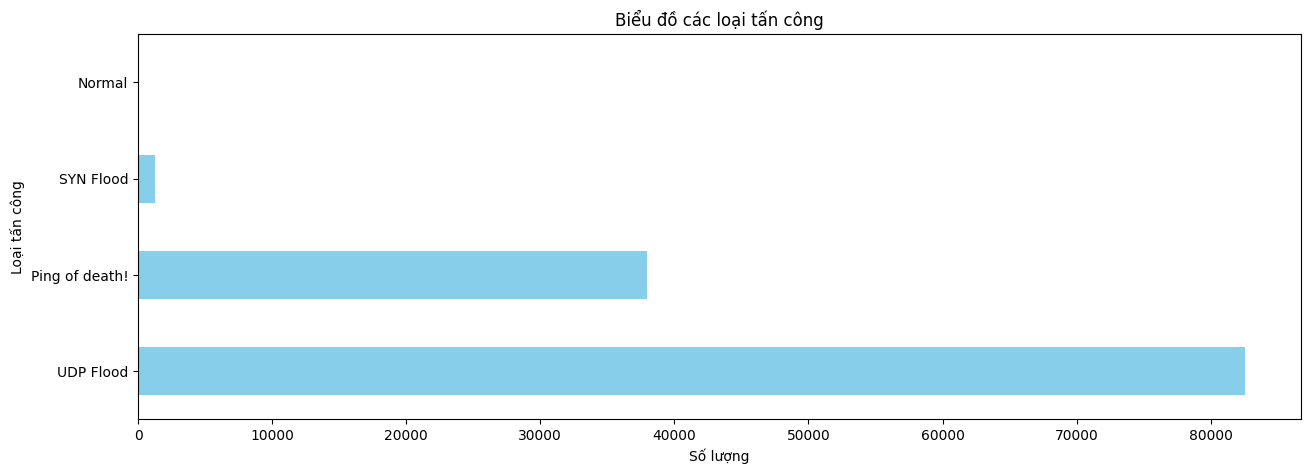

In [14]:
#Biểu đồ các loại tấn công
message_counts = data["Message"].value_counts()
message_counts.plot(kind='barh', figsize=(15, 5), color='skyblue')
plt.title('Biểu đồ các loại tấn công')
plt.xlabel('Số lượng')
plt.ylabel('Loại tấn công')
plt.show()


In [15]:
# Chỉ giữ các cột có nhiều hơn 1 giá trị duy nhất
data = data[[col for col in data if data[col].nunique() > 1]]
data

,SID,Message,Protocol,Src Port,Extra Port,Description,Priority,Src IP1,Src IP2,Src IP3,Src IP4,Dst IP1,Dst IP2,Dst IP3,Dst IP4
0,13,Normal,ICMP,28194.501873,135,Generic ICMP event,3,192,168,8,10,192,168,8,10
1,8,Normal,ICMP,28194.501873,135,Generic ICMP event,4,192,168,8,10,192,168,8,10
2,2,Normal,ICMP,28194.501873,135,Generic ICMP event,4,192,168,8,10,192,168,8,10
3,1,Ping of death!,ICMP,28194.501873,40480,Denial of Service,2,192,168,10,30,192,168,10,30
4,1,Ping of death!,ICMP,28194.501873,40481,Denial of Service,2,192,168,10,30,192,168,10,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121845,5,SYN Flood,TCP,62847.000000,40539,Detection of a Denial of Service Attack,2,54,134,244,223,54,134,244,223
121846,5,SYN Flood,TCP,7387.000000,28538,Detection of a Denial of Service Attack,2,140,91,163,79,140,91,163,79
121847,5,SYN Flood,TCP,14907.000000,45028,Detection of a Denial of Service Attack,2,232,41,169,121,232,41,169,121
121848,5,SYN Flood,TCP,31527.000000,3830,Detection of a Denial of Service Attack,2,174,99,238,61,174,99,238,61


In [16]:
# Tạo một khung dữ liệu với các nhãn nhiều lớp (Normal , Ping of death!, SYN Flood, UDP Flood, SQL injection )
Message = pd.DataFrame(data.Message)


In [17]:
# Mã hóa nhãn (0,1,2,3) nhãn nhiều lớp (Normal , Ping of death, SYN Flood, UDP Flood)
huhi = preprocessing.LabelEncoder()
huhu = Message.apply(huhi.fit_transform) #biến mỗi giá trị của cột Message thành giá trị số, lưu vào biến huhu
data['Intrusion'] = huhu #tạo cột Intrusion trong data và gán giá trị của huhu vào
print(data.shape)
data.head()


(121850, 16)


<ipython-input-17-c3f4a54fa665>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Intrusion'] = huhu #tạo cột Intrusion trong data và gán giá trị của huhu vào


,SID,Message,Protocol,Src Port,Extra Port,Description,Priority,Src IP1,Src IP2,Src IP3,Src IP4,Dst IP1,Dst IP2,Dst IP3,Dst IP4,Intrusion
0,13,Normal,ICMP,28194.501873,135,Generic ICMP event,3,192,168,8,10,192,168,8,10,0
1,8,Normal,ICMP,28194.501873,135,Generic ICMP event,4,192,168,8,10,192,168,8,10,0
2,2,Normal,ICMP,28194.501873,135,Generic ICMP event,4,192,168,8,10,192,168,8,10,0
3,1,Ping of death!,ICMP,28194.501873,40480,Denial of Service,2,192,168,10,30,192,168,10,30,1
4,1,Ping of death!,ICMP,28194.501873,40481,Denial of Service,2,192,168,10,30,192,168,10,30,1


In [18]:
#Loại bỏ cột 'Message' khi đã tạo cột 'Intrusion'
data.drop(labels= ['Message','Description'], axis=1, inplace=True)
print(data.shape)

(121850, 14)


<ipython-input-18-715f1dc5915f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(labels= ['Message','Description'], axis=1, inplace=True)


In [19]:
# cột phân loại one-hot-encoding
data = pd.get_dummies(data, columns=["Protocol"])
print(data.shape)
data.head()

(121850, 16)


,SID,Src Port,Extra Port,Priority,Src IP1,Src IP2,Src IP3,Src IP4,Dst IP1,Dst IP2,Dst IP3,Dst IP4,Intrusion,Protocol_ICMP,Protocol_TCP,Protocol_UDP
0,13,28194.501873,135,3,192,168,8,10,192,168,8,10,0,1,0,0
1,8,28194.501873,135,4,192,168,8,10,192,168,8,10,0,1,0,0
2,2,28194.501873,135,4,192,168,8,10,192,168,8,10,0,1,0,0
3,1,28194.501873,40480,2,192,168,10,30,192,168,10,30,1,1,0,0
4,1,28194.501873,40481,2,192,168,10,30,192,168,10,30,1,1,0,0


In [20]:
#Chia dữ liệu thành 2 phần : train và test
Y_data= np.array(data['Intrusion'])
X_data= np.array(data.drop(labels=['Intrusion'], axis=1).astype(np.float64))

print('X_train has shape:',X_data.shape,'\ny_train has shape:',Y_data.shape)


X_train has shape: (121850, 15) 
y_train has shape: (121850,)


In [21]:
print('X_train has shape:',X_data.shape,'\ny_train has shape:',Y_data.shape)

X_train has shape: (121850, 15) 
y_train has shape: (121850,)


In [22]:
X_data[0]

array([1.30000000e+01, 2.81945019e+04, 1.35000000e+02, 3.00000000e+00,
       1.92000000e+02, 1.68000000e+02, 8.00000000e+00, 1.00000000e+01,
       1.92000000e+02, 1.68000000e+02, 8.00000000e+00, 1.00000000e+01,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [23]:
#chia dữ liệu thành tập huấn luyện và tập kiểm thử
X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_data, test_size=0.20, random_state=42)
print(X_train.shape,'\n',X_test.shape)

(97480, 15) 
 (24370, 15)


In [24]:
#chuẩn hóa dữ liệu
std_scaler = StandardScaler()
X_data=std_scaler .fit_transform(X_data)

In [25]:
#X_train, Y_train được sử dụng để huấn luyện mô hình (tập huấn luyện cuối cùng)
#X_val , Y_val sử dụng để đánh giá hiệu suất của mô hình trong quá trình huấn luyện (tập validation)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

In [26]:
X_train[0]

array([6.0000e+00, 4.6763e+04, 4.2000e+01, 2.0000e+00, 1.9200e+02,
       1.6800e+02, 8.0000e+00, 1.0000e+01, 1.9200e+02, 1.6800e+02,
       8.0000e+00, 1.0000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00])

In [27]:
print(X_train.shape, Y_train.shape)

(77984, 15) (77984,)


In [28]:
# Xây dựng mô hình CNN1D
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(15, 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 nhãn dữ liệu
#Summary model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 32)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 64)             6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               1

In [29]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
from keras.utils import to_categorical
Y_train_cat=to_categorical(Y_train)
Y_val_cat=to_categorical(Y_val)

In [31]:
# Huấn luyện mô hình
his=model.fit(X_train, Y_train_cat, epochs=50, batch_size=32, validation_data=(X_val,Y_val_cat),)

Epoch 1/50
2437/2437 [==============================] - 28s 10ms/step - loss: 10.1115 - accuracy: 0.9692 - val_loss: 0.0701 - val_accuracy: 0.9905
Epoch 2/50
2437/2437 [==============================] - 17s 7ms/step - loss: 0.1011 - accuracy: 0.9827 - val_loss: 0.0544 - val_accuracy: 0.9877
Epoch 3/50
2437/2437 [==============================] - 12s 5ms/step - loss: 0.1069 - accuracy: 0.9844 - val_loss: 0.0235 - val_accuracy: 0.9949
Epoch 4/50
2437/2437 [==============================] - 12s 5ms/step - loss: 0.0664 - accuracy: 0.9888 - val_loss: 0.0160 - val_accuracy: 0.9991
Epoch 5/50
2437/2437 [==============================] - 12s 5ms/step - loss: 0.0617 - accuracy: 0.9910 - val_loss: 0.0149 - val_accuracy: 0.9984
Epoch 6/50
2437/2437 [==============================] - 12s 5ms/step - loss: 0.0587 - accuracy: 0.9900 - val_loss: 0.0062 - val_accuracy: 0.9989
Epoch 7/50
2437/2437 [==============================] - 11s 4ms/step - loss: 0.0600 - accuracy: 0.9878 - val_loss: 0.0334 - val_

In [32]:
# dự đoán thuộc tính đích trên tập dữ liệu thử nghiệm
Y_test_cat=to_categorical(Y_test)
test_results = model.evaluate(X_test, Y_test_cat, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

762/762 [==============================] - 1s 2ms/step - loss: 0.0044 - accuracy: 0.9998
Test results - Loss: 0.004414531867951155 - Accuracy: 99.97537732124329%


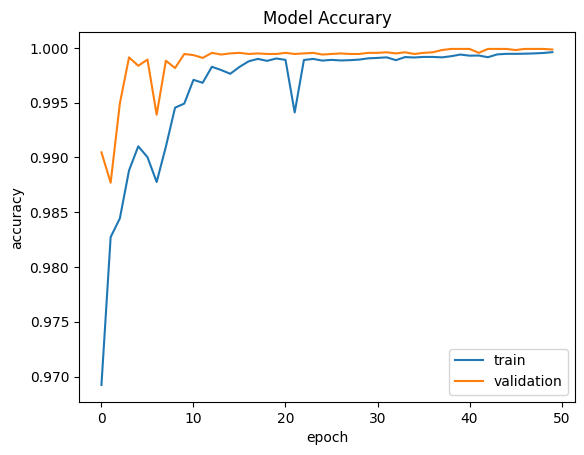

In [33]:
# Biểu đồ độ chính xác so với epoch cho tập dữ liệu thử nghiệm và huấn luyện
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title("Model Accurary")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

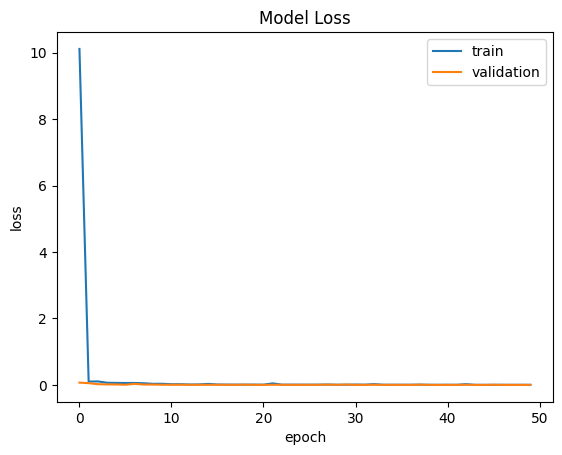

In [34]:
# Biểu đồ độ mất mát so với epoch cho tập dữ liệu thử nghiệm và huấn luyện
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title("Model Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()